# 🛠 08. Introduction to NLP (Natural Language Processing) in TensorFlow Exercises

1. Rebuild, compile and train model_1, model_2 and model_5 using the Keras Sequential API instead of the Functional API.
2. Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?
3. Try fine-tuning the TF Hub Universal Sentence Encoder model by setting training=True when instantiating it as a Keras layer.

``` We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model ```
4. Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the sample_submission.csv file from Kaggle (see the Files tab in Colab for what the sample_submission.csv file looks like). Once you've done this, make a submission to the Kaggle competition, how did your model perform?
5. Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?
6. Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

## 8.1 Rebuild Models using Sequential API

In [1]:
import tensorflow as tf

### Import Helper Functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-01 15:08:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-01 15:08:29 (93.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import 
from helper_functions import unzip_data,create_tensorboard_callback,plot_loss_curves,compare_historys,calculate_results

### Get a text dataset

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2023-02-01 15:08:36--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.01s   

2023-02-01 15:08:36 (54.3 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
# Unzip data
unzip_data('nlp_getting_started.zip')

### Visualizing a text dataset

In [6]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1,random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does the test dataframe look like
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Let's visualize some random training examples
import random
random_index = random.randint(0,len(train_df)-5)
for row in train_df_shuffled[['text','target']][random_index:random_index+5].itertuples():
  _,text,target = row
  print(f'Target: {target}', "(real disaster)" if target > 0 else '(not real disaster)')
  print(f"Text: {text}\n")

Target: 0 (not real disaster)
Text: SHOUOUT TO @kasad1lla CAUSE HER VOCALS ARE BLAZING HOT LIKE THE WEATHER SHES IN

Target: 1 (real disaster)
Text: driving the avalanche after having my car for a week is like driving a tank

Target: 0 (not real disaster)
Text: @aptly_engineerd There is no such curfew.

Target: 1 (real disaster)
Text: Three Israeli soldiers wounded in West Bank terrorist attack via /r/worldnews http://t.co/9TyucdWh3g

Target: 0 (not real disaster)
Text: Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/4oNvxncz8w http://t.co/tnggXNm6k8



### Split data into training and test sets

In [8]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [ ]:
# Check the lengths
len(train_sentences),len(val_sentences),len(train_labels),len(val_labels)

(6851, 762, 6851, 762)

In [ ]:
# Check first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

### Creating the text vectorizer Layer

In [ ]:
# Find the average number of tokens in the training tweets
round(sum([len(i.split()) for i in train_sentences])/ len(train_sentences))

15

In [9]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, #How many different words in the vocabulary (automatically add <oov>)
                                    standardize = 'lower_and_strip_punctuation',
                                    output_mode='int', # how to map tokens to numbers
                                    output_sequence_length=max_length, # how long do you want your sequence to be
                                    )

In [10]:
# Fit the text vectorizer to training data
text_vectorizer.adapt(train_sentences)

### Creating the Embedding Layer

In [11]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,                     
                             input_length=max_length)
embedding

### Model 1


* inputs = layers.Input(shape=(1,),dtype=tf.string) # inputs are 1 dimensional strings

* x = text_vectorizer(inputs) # turn the input text into numbers

* x = embedding(x) # create an embedding of the numberized inputs

* x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality

* outputs = layers.Dense(1,activation='sigmoid')(x)

* model_1  = tf.keras.Model(inputs,outputs,
name='model_1_dense')

In [32]:
# Create a tensorflow callback
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = 'model_logs'

In [33]:
model_1 = tf.keras.Sequential([
    
    text_vectorizer,
    tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),
                             output_dim=128,                     
                             input_length=max_length),
    tf.keras.layers.Dense(128),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1,activation='sigmoid')
                                    
])

In [34]:
model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [35]:
train_sentences.shape

(6851,)

In [36]:
history_1 = model_1.fit(x = train_sentences,
                        y = train_labels,
                        epochs = 5,
                        validation_data = (val_sentences,val_labels),
                        callbacks = [create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name='model_1_dense')]
                        )

Saving TensorBoard log files to: model_logs/model_1_dense/20230201-152425
Epoch 1/5
215/215 [==============================] - 3s 9ms/step - loss: 0.5262 - accuracy: 0.7374 - val_loss: 0.4584 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3218 - accuracy: 0.8692 - val_loss: 0.4825 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2221 - accuracy: 0.9130 - val_loss: 0.5910 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1631 - accuracy: 0.9369 - val_loss: 0.6477 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1250 - accuracy: 0.9578 - val_loss: 0.7750 - val_accuracy: 0.7703


In [37]:
# Check the results
model_1.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.7750 - accuracy: 0.7703


[0.7750276327133179, 0.7703412175178528]

In [38]:
# Make some predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.35635144],
       [0.25608978],
       [0.99974036],
       [0.018409  ],
       [0.0032233 ],
       [0.9867607 ],
       [0.8077078 ],
       [0.9999389 ],
       [0.99981254],
       [0.46021694]], dtype=float32)

In [39]:
# Map to labels
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [40]:
# Calculate model 2 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.03412073490814,
 'precision': 0.7739543961790544,
 'recall': 0.7703412073490814,
 'f1': 0.7673435495786338}

### Model 2


Create an LSTM model

* input = layers.Input(shape=(1,),dtype='string')

* x = text_vectorizer(inputs)

* x = embedding(x)

* x = layers.LSTM(64)(x)

* outputs = layers.Dense(1,activation = 'sigmoid')(x)

* model_2 = tf.keras.Model(inputs,outputs,name = 'model_2_LSTM')

In [41]:
# Build the model
model_2 = tf.keras.Sequential([
    text_vectorizer,
    tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),
                             output_dim=128,                     
                             input_length=max_length),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [42]:
# Compile the model
model_2.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [43]:
# Fit the model
history_2 = model_2.fit(x = train_sentences,
                        y = train_labels,
                        epochs = 10,
                        validation_data = (val_sentences,val_labels),
                        callbacks = [create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name='model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230201-152437
Epoch 1/10
215/215 [==============================] - 5s 17ms/step - loss: 0.5197 - accuracy: 0.7289 - val_loss: 0.4602 - val_accuracy: 0.7861
Epoch 2/10
215/215 [==============================] - 4s 16ms/step - loss: 0.3176 - accuracy: 0.8713 - val_loss: 0.5249 - val_accuracy: 0.7769
Epoch 3/10
215/215 [==============================] - 3s 15ms/step - loss: 0.2147 - accuracy: 0.9218 - val_loss: 0.5434 - val_accuracy: 0.7756
Epoch 4/10
215/215 [==============================] - 3s 16ms/step - loss: 0.1485 - accuracy: 0.9431 - val_loss: 0.6722 - val_accuracy: 0.7651
Epoch 5/10
215/215 [==============================] - 3s 15ms/step - loss: 0.0962 - accuracy: 0.9650 - val_loss: 0.8155 - val_accuracy: 0.7730
Epoch 6/10
215/215 [==============================] - 3s 15ms/step - loss: 0.0751 - accuracy: 0.9702 - val_loss: 1.0673 - val_accuracy: 0.7664
Epoch 7/10
215/215 [==============================] - 3s 15ms/step - 

In [44]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)

24/24 [==============================] - 0s 3ms/step


In [45]:
# Conver model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))

In [46]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.29658792650919,
 'precision': 0.7753400570774207,
 'recall': 0.7729658792650919,
 'f1': 0.7705764257839071}

### Model 05

* inputs = layers.Input(shape=(1,),dtype=tf.string)

* x = text_vectorizer(inputs)

* x = embedding(x)

* x = layers.Conv1D(filters=64,kernel_size=5,activation='relu',strides=1,padding='valid')(x)

* x = layers.GlobalAveragePooling1D()(x)

* outputs = layers.Dense(1,activation='sigmoid')(x)

* model_5 = tf.keras.Model(inputs,outputs,name='model_5_Conv1D')

In [17]:
# Build the model
model_5 = tf.keras.Sequential([
    text_vectorizer,
    embedding,
    tf.keras.layers.Conv1D(filters=64,kernel_size=5,activation='relu',padding='valid'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [18]:
# Compile the model
model_5.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [20]:
# Fit the model
history_5 = model_5.fit(x = train_sentences,
                        y = train_labels,
                        epochs = 10,
                        validation_data = (val_sentences,val_labels),
                        callbacks = [create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name='model_5_Conv1D')] )

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20230201-151815
Epoch 1/10
215/215 [==============================] - 3s 10ms/step - loss: 0.5351 - accuracy: 0.7298 - val_loss: 0.4695 - val_accuracy: 0.7782
Epoch 2/10
215/215 [==============================] - 2s 9ms/step - loss: 0.3309 - accuracy: 0.8606 - val_loss: 0.5027 - val_accuracy: 0.7822
Epoch 3/10
215/215 [==============================] - 2s 9ms/step - loss: 0.2268 - accuracy: 0.9101 - val_loss: 0.5921 - val_accuracy: 0.7717
Epoch 4/10
215/215 [==============================] - 2s 10ms/step - loss: 0.1586 - accuracy: 0.9397 - val_loss: 0.7295 - val_accuracy: 0.7664
Epoch 5/10
215/215 [==============================] - 2s 10ms/step - loss: 0.1190 - accuracy: 0.9523 - val_loss: 0.8218 - val_accuracy: 0.7480
Epoch 6/10
215/215 [==============================] - 2s 10ms/step - loss: 0.0919 - accuracy: 0.9660 - val_loss: 0.9269 - val_accuracy: 0.7493
Epoch 7/10
215/215 [==============================] - 2s 10ms/step - 

In [22]:
# Validate the model
model_5.evaluate(val_sentences,val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 1.2925 - accuracy: 0.7493


[1.2925167083740234, 0.7493438124656677]

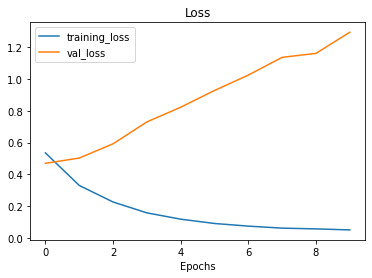

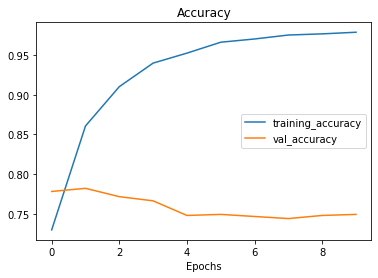

In [28]:
# Plot the loss curves
plot_loss_curves(history_5)

In [24]:
# Predict
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[2.4480660e-01],
       [9.8428786e-01],
       [9.9999911e-01],
       [1.9339709e-02],
       [3.4601802e-05],
       [9.9699289e-01],
       [1.8895790e-01],
       [9.9999344e-01],
       [1.0000000e+00],
       [1.2124062e-01]], dtype=float32)

In [27]:
# Map to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [30]:
# Check the scores of the model
model_5_results = calculate_results(val_labels,model_5_preds)
model_5_results

{'accuracy': 74.93438320209974,
 'precision': 0.7512456879811593,
 'recall': 0.7493438320209974,
 'f1': 0.7465531243537884}

### Compare accuracies of 3 models

In [47]:
# Combine model results into a DataFrame
all_models_results = pd.DataFrame({
                                   '1_simple_dense': model_1_results,
                                   '2_lstm': model_2_results,
                                   '5_convo1d': model_5_results,
                                   })

In [48]:
all_models_results

,1_simple_dense,2_lstm,5_convo1d
accuracy,77.034121,77.296588,74.934383
precision,0.773954,0.775340,0.751246
recall,0.770341,0.772966,0.749344
f1,0.767344,0.770576,0.746553
